In [668]:
import sys
import os
import pandas as pd
import numpy as np
sys.path.append(os.path.abspath("../"))  # Adds 'src' to the module search path
sys.path.append(os.path.abspath("../src"))  # Adds 'src' to the module search path

In [669]:
from plot import *
import matplotlib.pyplot as plt
import re

In [670]:
TRACE_TASKS = '../results/pipeline_statistics/trace_tasks.tsv'
TRACE_CAL = '../results/pipeline_statistics/trace_cal.tsv'
TRACE_PARQUET = '../results/pipeline_statistics/trace_parquet.tsv'

In [671]:
df_tasks = pd.read_csv(TRACE_TASKS, sep='\t')
df_calibration = pd.read_csv(TRACE_CAL, sep='\t')
df_parquet = pd.read_csv(TRACE_PARQUET, sep='\t')
df_parquet.head()

,task_id,hash,native_id,name,status,exit,submit,duration,realtime,%cpu,peak_rss,peak_vmem,rchar,wchar
0,1,ca/a064b3,2030938,to_parquet:TO_PARQUET (1),COMPLETED,0,2025-05-08 07:19:01.411,2m 28s,2m 18s,80.3%,11.0 GB,12.5 GB,12.6 GB,7.9 GB


In [672]:
df_calibration.head()

,task_id,hash,native_id,name,status,exit,submit,duration,realtime,%cpu,peak_rss,peak_vmem,rchar,wchar
0,39,74/b29631,2030787,calibrate:CALIBRATE (39),COMPLETED,0,2025-05-08 05:27:06.744,45.3s,38.6s,94.2%,656.7 MB,1011.9 MB,227.6 MB,3.9 MB
1,44,9b/872b13,2030791,calibrate:CALIBRATE (44),COMPLETED,0,2025-05-08 05:27:09.004,43.2s,38.5s,94.3%,640 MB,995.9 MB,228.2 MB,4.5 MB
2,1,a0/fedad9,2030749,calibrate:CALIBRATE (1),COMPLETED,0,2025-05-08 05:26:44.751,2m 27s,2m 20s,96.9%,641.8 MB,996.9 MB,229.9 MB,6.5 MB
3,51,72/f7d0f8,2030799,calibrate:CALIBRATE (51),COMPLETED,0,2025-05-08 05:27:53.351,1m 39s,1m 32s,96.2%,642.8 MB,997.9 MB,232 MB,9.1 MB
4,18,6d/57d0db,2030765,calibrate:CALIBRATE (18),COMPLETED,0,2025-05-08 05:26:54.252,3m 33s,3m 27s,97.8%,649.1 MB,1001.9 MB,239.9 MB,18 MB


In [673]:
df_tasks['type'] = 'tasks'
df_calibration['type'] = 'calibration'
df_parquet['type'] = 'parquet'
df = pd.concat([df_tasks, df_calibration], ignore_index=True)

In [674]:
def convert_to_minutes(time_str):
    # Handle NaN values
    if pd.isna(time_str):
        return None
    
    # Convert to string if not already
    time_str = str(time_str).strip()
    
    # Extract hours, minutes and seconds using regex
    hours = re.search(r'(\d+)h', time_str)
    minutes = re.search(r'(\d+)m', time_str)
    seconds = re.search(r'(\d+)\s*s', time_str)
    
    # Convert to minutes
    total_minutes = 0
    
    if hours:
        total_minutes += int(hours.group(1)) * 60
    
    if minutes:
        total_minutes += int(minutes.group(1))
    
    if seconds:
        total_minutes += int(seconds.group(1)) / 60
    
    return total_minutes

def convert_to_mb(size_str):
    # Handle NaN values
    if pd.isna(size_str):
        return None
    
    # Convert to string if not already
    size_str = str(size_str).strip()
    
    # Extract gigabytes and megabytes using regex
    gb = re.search(r'(\d+\.?\d*)\s*GB', size_str, re.IGNORECASE)
    mb = re.search(r'(\d+\.?\d*)\s*MB', size_str, re.IGNORECASE)
    
    # Convert to megabytes
    total_mb = 0
    
    if gb:
        total_mb += float(gb.group(1)) * 1024  # 1 GB = 1024 MB
    
    if mb:
        total_mb += float(mb.group(1))
    
    return total_mb

def convert_percentage_to_decimal(percent_str):
    match = re.search(r'(\d+(\.\d+)?)%', percent_str)
    return float(match.group(1)) / 100
    
    return percent_str
    
def convert_percentage_to_decimal(percent_str):
    """Convert percentage strings like '56.8%' to decimal values"""
    if not isinstance(percent_str, str):
        return percent_str
    
    match = re.search(r'(\d+(\.\d+)?)%', percent_str)
    if match:
        return float(match.group(1)) / 100
    
    return percent_str

df['duration'] =df['duration'].apply(convert_to_minutes)
df['%cpu'] =df['%cpu'].apply(convert_percentage_to_decimal)

df['peak_rss'] =df['peak_rss'].apply(convert_to_mb)
df['rchar'] =df['rchar'].apply(convert_to_mb)
df['wchar'] =df['wchar'].apply(convert_to_mb)

### Global info

In [676]:
task_counts = df_tasks.groupby('exit')['task_id'].count()

C:\Users\lambe\Documents\School\thesis\MTL-peptide-property-prediction_temp\src\plot.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


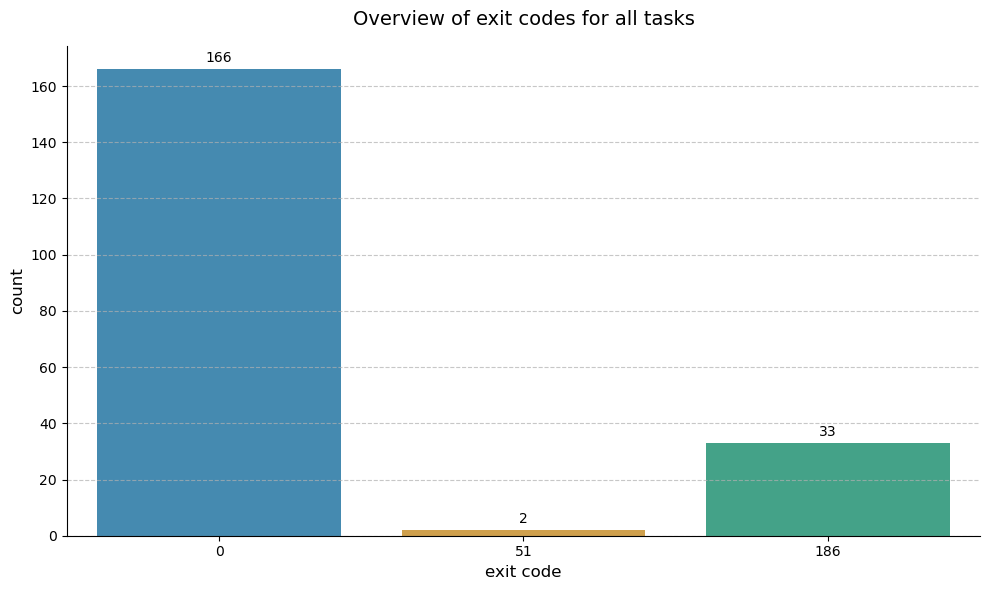

In [677]:
# Call the plotting function with the Series
plot_bar_vertical(
    data_series=task_counts,
    title="Overview of exit codes for all tasks",
    xlabel="exit code",
    ylabel="count",
    figsize=(10, 6),
)

In [678]:
def create_category_boxplot(df, value_column,title, ylabel="time (minutes)", category_column='type', figsize=(10, 6)):

    
    # Count the number of datapoints in each category
    category_counts = df[category_column].value_counts().to_dict()
    
    # Create side-by-side boxplots
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(
        x=category_column,
        y=value_column,
        data=df,
        palette=['lightblue', 'lightgreen'],
        linewidth=1.5,
        fliersize=5,
        ax=ax
    )
    

    
    # Customize labels and title
    plt.xlabel('', fontsize=12)  # You can leave this blank or customize
    plt.ylabel(ylabel, fontsize=12, labelpad=10)
    plt.title(title, fontsize=14, pad=15)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    
    # Tight layout
    plt.tight_layout()
    
    plt.show()

In [679]:
par = df[df['type']=='parquet']

In [680]:
par = par[par['status']=='COMPLETED']

In [681]:
par

,task_id,hash,native_id,name,status,exit,submit,duration,realtime,%cpu,peak_rss,peak_vmem,rchar,wchar,type


In [682]:
df

,task_id,hash,native_id,name,status,exit,submit,duration,realtime,%cpu,peak_rss,peak_vmem,rchar,wchar,type
0,2,0e/0019fc,2030271,run_tasks:CREATE_PSMS (2),FAILED,186,2025-05-07 18:38:56.608,0.100000,4.9s,-,0.0,-,0.0,0.0,tasks
1,11,04/21ba6e,2030281,run_tasks:CREATE_PSMS (11),FAILED,186,2025-05-07 18:39:03.472,0.033333,5s,-,0.0,-,0.0,0.0,tasks
2,12,16/22bc9d,2030282,run_tasks:CREATE_PSMS (12),COMPLETED,0,2025-05-07 18:39:13.177,7.400000,7m 17s,0.568,415.2,582.1 MB,85299.2,1843.2,tasks
3,7,60/f146eb,2030277,run_tasks:CREATE_PSMS (7),COMPLETED,0,2025-05-07 18:39:00.302,24.616667,24m 34s,0.444,1433.6,1.6 GB,478822.4,6860.8,tasks
4,15,0c/3227d1,2030306,run_tasks:CREATE_PSMS (15),FAILED,186,2025-05-07 19:03:38.262,0.066667,4.5s,-,0.0,-,0.0,0.0,tasks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,41,64/cb53c5,2030788,calibrate:CALIBRATE (41),COMPLETED,0,2025-05-08 05:27:07.405,88.333333,1h 28m 13s,0.995,751.9,1.1 GB,311.0,99.3,calibration
362,115,03/5ab828,2030865,calibrate:CALIBRATE (115),COMPLETED,0,2025-05-08 05:43:42.793,76.483333,1h 16m 23s,0.995,790.5,1.1 GB,313.3,101.9,calibration
363,57,95/f9562f,2030804,calibrate:CALIBRATE (57),COMPLETED,0,2025-05-08 05:30:28.148,94.650000,1h 34m 34s,0.996,752.7,1.1 GB,313.5,102.2,calibration
364,136,cc/6e7c5d,2030886,calibrate:CALIBRATE (136),COMPLETED,0,2025-05-08 05:47:27.700,90.900000,1h 30m 48s,0.995,789.4,1.1 GB,311.5,99.9,calibration


C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


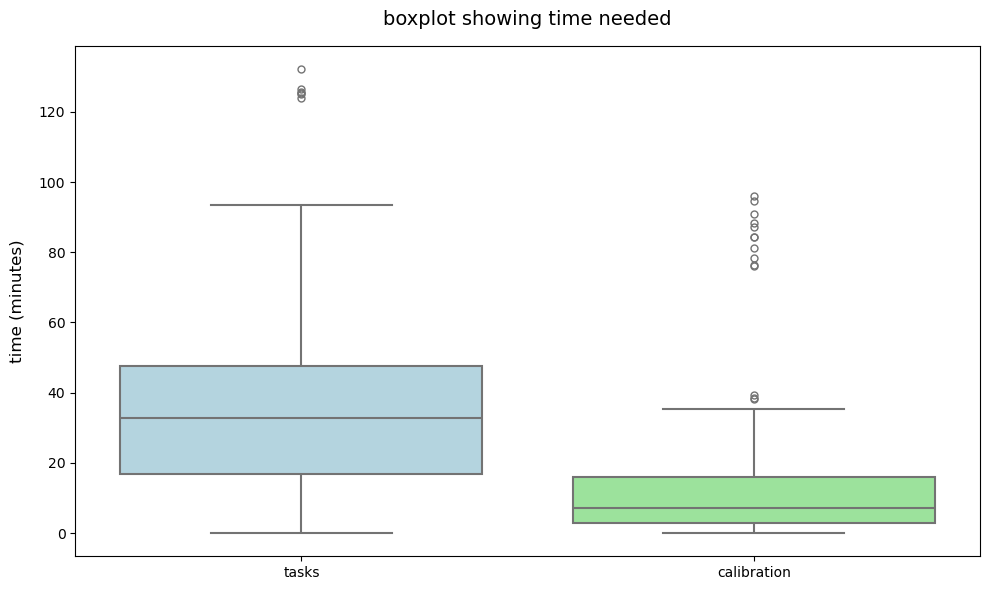

In [683]:
filtered_df = df[df['status']=='COMPLETED']
create_category_boxplot(filtered_df,'duration',"boxplot showing time needed","time (minutes)")

C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


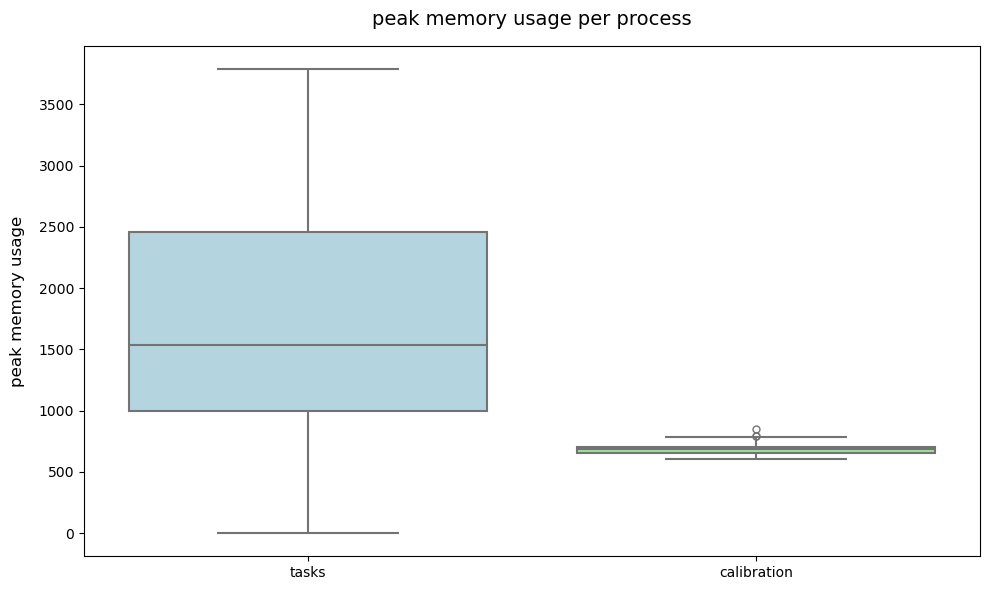

In [684]:
create_category_boxplot(filtered_df,'peak_rss',"peak memory usage per process","peak memory usage")

C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


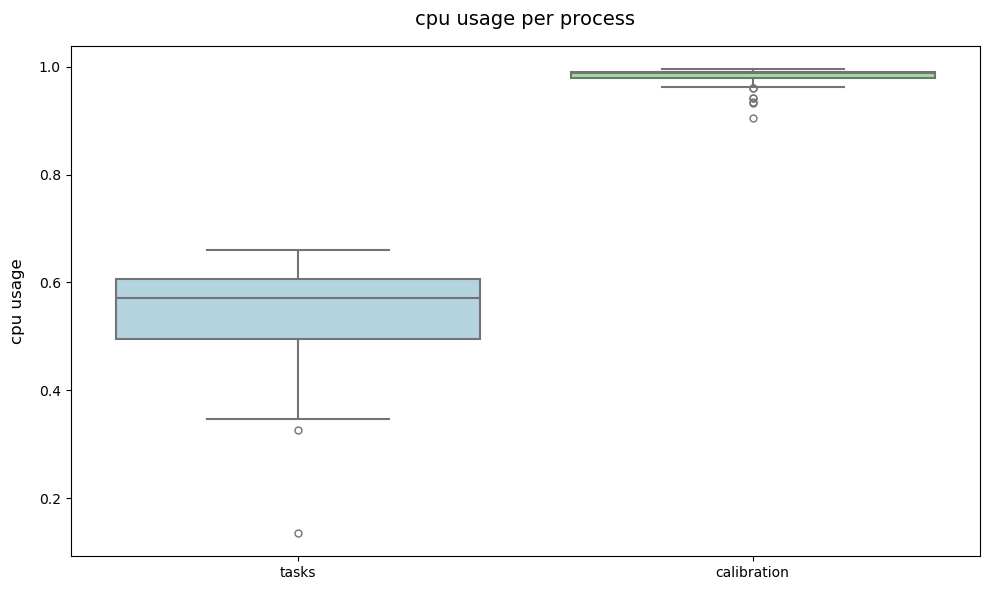

In [685]:
create_category_boxplot(filtered_df,'%cpu',"cpu usage per process","cpu usage")

C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


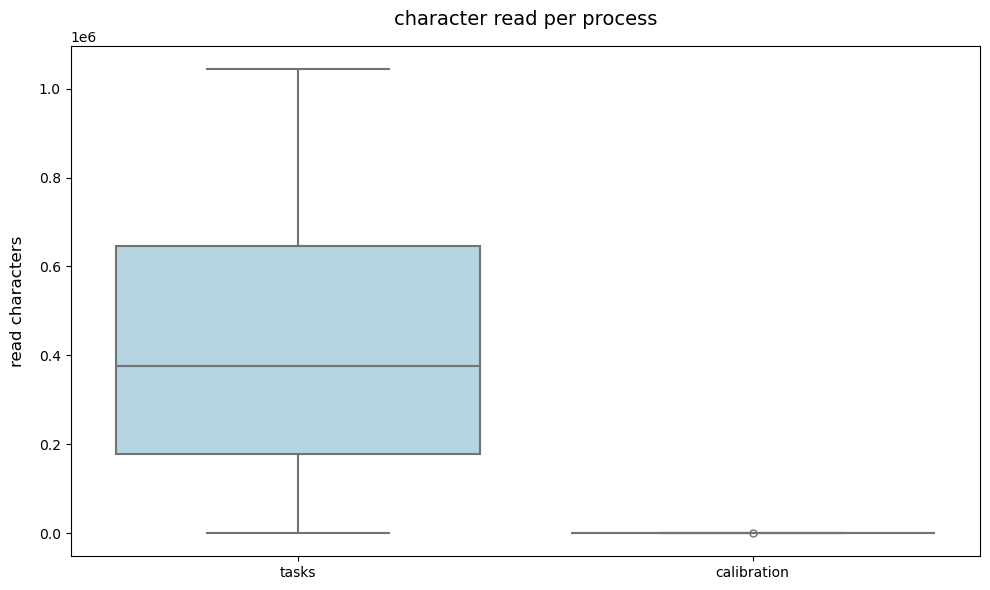

In [686]:
create_category_boxplot(filtered_df,'rchar',"character read per process","read characters")

C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lambe\AppData\Local\Temp\ipykernel_42776\932666809.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


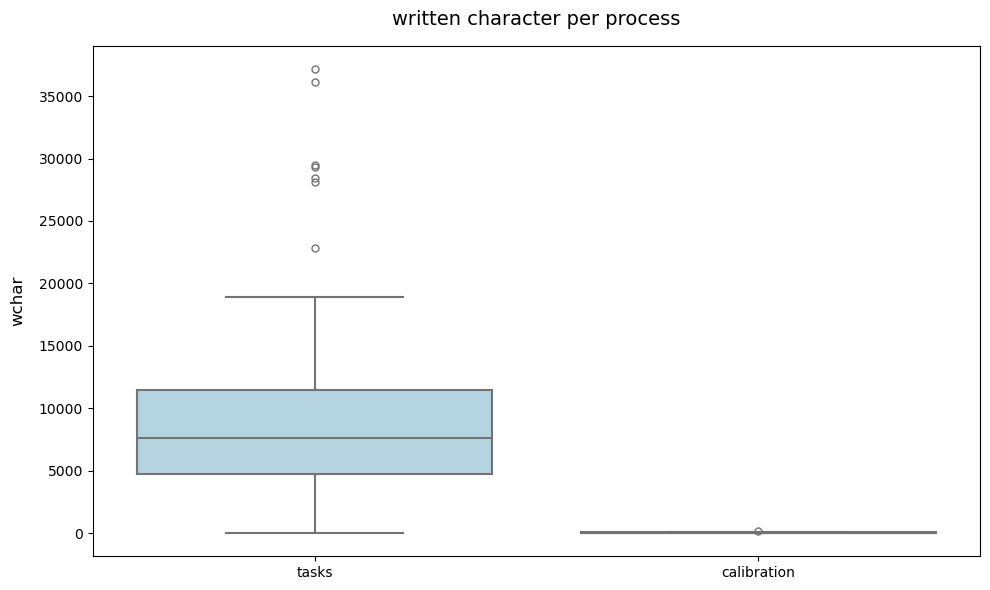

In [687]:
create_category_boxplot(filtered_df,'wchar',"written character per process","wchar")